In [4]:
import numpy as np
import pandas as pd

import plotly.graph_objects as go

In [2]:
rng = np.random.default_rng()

## Volatility signature 

$$ C(\tau) = \dfrac{1}{T} \sum_{n=0}^{T/\tau} |(X(n + 1)\tau) - X(n\tau)|^2 $$

where, 

$X(t)$ is the price of future at time $t$  
$\tau$ is the sampling frequency  
$[0, T]$ is the window length

## Theoretical signature of a Hawkes process

$$ C(\tau) = \Lambda \left(  k^2 + (1 - k^2) \dfrac{1 - e^{-\gamma t}}{\gamma t}  \right) $$

where, 

$$ \Lambda = \dfrac{2\mu}{1 - \kappa} $$

$$ k = \dfrac{1}{1 + \kappa} $$

$$ \gamma = \beta(\kappa + 1) $$

In [42]:
class MHP:
    def __init__(self, alpha: np.ndarray, mu: np.ndarray, omega: float):
        '''params should be of form:
        alpha: numpy.array((u,u)), mu: numpy.array((,u)), omega: float'''
        
        self.data = []
        self.alpha, self.mu, self.omega = alpha, mu, omega
        self.dim = self.mu.shape[0]
        self.check_stability()

    def check_stability(self):
        ''' check stability of process (max alpha eigenvalue < 1)'''
        w,v = np.linalg.eig(self.alpha)
        me = np.amax(np.abs(w))
        print('Max eigenvalue: %1.5f' % me)
        if me >= 1.:
            print('(WARNING) Unstable.')
            
    
    def generate_seq(self, horizon):
        '''Generate a sequence based on mu, alpha, omega values. 
        Uses Ogata's thinning method, with some speedups, noted below'''

        self.data = []  # clear history

        Istar = np.sum(self.mu)
        s = np.random.exponential(scale=1./Istar)

        # attribute (weighted random sample, since sum(mu)==Istar)
        n0 = np.random.choice(np.arange(self.dim), 
                              1, 
                              p=(self.mu / Istar))
        self.data.append([s, n0])

        # value of \lambda(t_k) where k is most recent event
        # starts with just the base rate
        lastrates = self.mu.copy()

        decIstar = False
        while True:
            tj, uj = self.data[-1][0], int(self.data[-1][1])

            if decIstar:
                # if last event was rejected, decrease Istar
                Istar = np.sum(rates)
                decIstar = False
            else:
                # otherwise, we just had an event, so recalc Istar (inclusive of last event)
                Istar = np.sum(lastrates) + \
                        self.omega * np.sum(self.alpha[:,uj])

            # generate new event
            s += np.random.exponential(scale=1./Istar)

            # calc rates at time s (use trick to take advantage of rates at last event)
            rates = self.mu + np.exp(-self.omega * (s - tj)) * \
                    (self.alpha[:,uj].flatten() * self.omega + lastrates - self.mu)

            # attribution/rejection test
            # handle attribution and thinning in one step as weighted random sample
            diff = Istar - np.sum(rates)
            try:
                n0 = np.random.choice(np.arange(self.dim+1), 1, 
                                      p=(np.append(rates, diff) / Istar))
            except ValueError:
                # by construction this should not happen
                print('Probabilities do not sum to one.')
                self.data = np.array(self.data)
                return self.data

            if n0 < self.dim:
                self.data.append([s, n0])
                # update lastrates
                lastrates = rates.copy()
            else:
                decIstar = True

            # if past horizon, done
            if s >= horizon:
                self.data = np.array(self.data, dtype=object)
                self.data = self.data[self.data[:,0] < horizon]
                return self.data

In [43]:
m = MHP(np.array([[0.24]]), np.array([0.74]), 0.19)

Max eigenvalue: 0.24000


In [58]:
seq = m.generate_seq(100)

In [13]:
def hawkes_process(tau: float, mu: float, kappa: float, beta: float):
    Lambda = 2 * mu / (1 - kappa)
    k = 1 / (1 + kappa)
    gamma = beta * (kappa + 1)
    return Lambda * (k**2 + (1 - k**2) * (1 - np.exp(-gamma * tau)) / (gamma * tau))

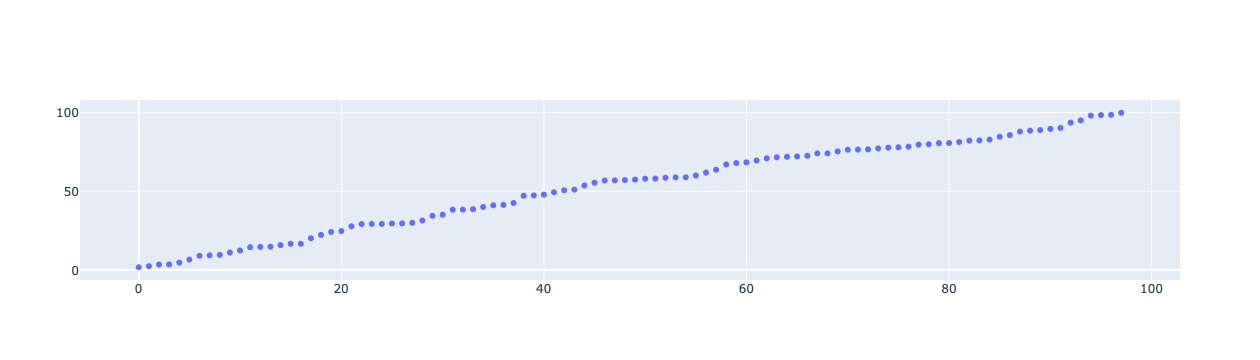

In [59]:
taus = np.linspace(0.1, 100, 1000)

fig = go.Figure()

#fig.add_scatter(
#    x=taus,
#    y=hawkes_process(taus, 0.24, 0.74, 0.19),
#    mode="markers"
#)

fig.add_scatter(
    y=seq[:, 0],
    mode="markers"
)

